# Optimization with Reinforcement Learning

In this tutorial, we show how different model types within DrugEx can be optimized under the reinforcement learning framework. The models can be taught to generate compounds according to multiple custom rewards and using several optimization strategies. In this tutorial, we review some of the most important scoring functions and optimization strategies on a simple hypothetical example, which will be focused on searching for selective ligands for the adenosine A3 receptor (A3R). In order to do that, we will build two QSAR models that will predict activity on A3R, but also adenosine A1 receptor (A1R). We will then use predictions from these models to generate compounds more selective towards A3R rather than A1R. In practice, this would be a really difficult task because A3R and A1R receptors have very similar binding sites so it would be really hard to use a purely ligand-based approach like this. However, it will serve us well here for the sake of example.


## QSAR Models 

In this section, we create the QSAR models that will serve as the source of rewards in our reinforcement learning framework. They will be built from selected subsets of the `LIGAND` data set (also used in [finetuning](finetuning.ipynb)):

In [1]:
GPUS = [0]
EPOCHS = 3

In [2]:
import pandas as pd

mol_col = 'Smiles'
activity_col = 'pChEMBL_Value'
target_col = 'Target_ChEMBL_ID'
columns = (mol_col, activity_col, target_col)

df = pd.read_csv(
    'jupyter/data/LIGAND_RAW_small.tsv', 
    na_values=('NA', 'nan', 'NaN'), 
    header=0, 
    sep='\t', 
    usecols=columns
)
df.dropna(subset=[activity_col, target_col], inplace=True)
df.head()

,Smiles,pChEMBL_Value,Target_ChEMBL_ID
0,CCCCn1cc2c(nc(NC(=O)Nc3ccc(Cl)c(Cl)c3)n3nc(-c4...,8.43,CHEMBL256
1,O=C(Cc1ccccc1)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3c...,7.35,CHEMBL256
2,O=C(COc1ccccc1)Nc1nc2nn(CCc3ccccc3)cc2c2nc(-c3...,6.52,CHEMBL256
3,CC(C)(C)NC(=O)Nc1nc2nn(CCCc3ccccc3)cc2c2nc(-c3...,7.19,CHEMBL256
4,COc1ccc(-n2cc3c(n2)c(N)nc2ccccc23)cc1,7.04,CHEMBL256


In [3]:
df.shape

(266, 3)

We have data for quite a few adenosine receptor subtypes in this set:

In [4]:
df[target_col].value_counts()

CHEMBL318     60
CHEMBL256     55
CHEMBL226     45
CHEMBL251     44
CHEMBL302     44
CHEMBL255     16
CHEMBL3360     1
CHEMBL2592     1
Name: Target_ChEMBL_ID, dtype: int64

However, we will only use data for A1R (ID=`CHEMBL318`) and A3R (ID=`CHEMBL256`).
Here we create two QSARdataset objects, which is a class to prepare the dataset for QSAR training.

In [5]:
from drugex.environment.data import QSARDataset

# Create dataset for A1R regression model
df_a1 = QSARDataset(input_df=df,
                    smilescol=mol_col,
                    targetcol=target_col,
                    valuecol=activity_col,
                    target="CHEMBL318",
                    keep_low_quality=True,
                    reg=True)

# create dataset with default settings (random train/test split 90%/10%)
df_a1.splitDataset()

# Minmax scaling
df_a1.X, df_a1.X_ind = df_a1.dataStandardization(df_a1.X, df_a1.X_ind)

print(f'A1R train set shape is: X: {df_a1.X.shape}, y: {df_a1.y.shape}')
print(f'A1R test set shape is: X: {df_a1.X_ind.shape}, y: {df_a1.y_ind.shape}')

# Create dataset for A3R regression model
df_a3 = QSARDataset(input_df=df,
                    smilescol=mol_col,
                    targetcol=target_col,
                    valuecol=activity_col,
                    target="CHEMBL256",
                    keep_low_quality=True,
                    reg=True)

# create dataset with default settings (random train/test split 90%/10%)
df_a3.splitDataset()

# Minmax scaling
df_a3.X, df_a3.X_ind = df_a3.dataStandardization(df_a3.X, df_a3.X_ind)

print(f'A3R train set shape is: {df_a3.X.shape}, y: {df_a3.y.shape}')
print(f'A3R test set shape is: {df_a3.X_ind.shape}, y: {df_a3.y_ind.shape}')


A1R train set shape is: X: (54, 2067), y: (54,)
A1R test set shape is: X: (6, 2067), y: (6,)
A3R train set shape is: (48, 2067), y: (48,)
A3R test set shape is: (6, 2067), y: (6,)


### Building the Models

Since this tutorial is only meant for demonstration purposes, we will not perform any further preprocessing of the data and just build two simple k-nearest neighbor models on the raw data using DrugEx built-in functions and interfaces:
This is of course not the proper way of doing things, but a more complex machine learning worflow could be envisaged here.

Now we will train two KNN regression models. First we will run bayes optimization for some of the hyperparameters.
Subsequently, we will run cross-validation for model evaluation and finally we will train the model on the
entire dataset for use in the reinforcement learning optimization.

In [6]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from drugex.environment.models import QSARsklearn
import os

# make output directory
if not os.path.isdir("envs"):
    os.mkdir("envs")

alg_name = "KNN" # Will be prefix of model save file

knn_a1 = QSARsklearn(base_dir = '.', data=df_a1, alg = KNeighborsRegressor(), alg_name=alg_name)
knn_a3 = QSARsklearn(base_dir = '.', data=df_a3, alg = KNeighborsRegressor(), alg_name=alg_name)

# search space can also be read in from json file using function QSARsklearn.loadParamsGrid(fname, "bayes", alg_name)
search_space_bs = {"n_neighbors": ["int", 5, 10],
                   "weights": ["categorical", ["uniform", "distance"]],
                   "metric": ["categorical", ["euclidean","manhattan", "chebyshev","minkowski"]]}

# n_trials=5 for example, but for thorough search should be higher
# if save_m = True model will be refit with the best parameters on all data, same as calling fit() after optimzation
knn_a1.bayesOptimization(search_space_bs=search_space_bs, n_trials=5)
knn_a3.bayesOptimization(search_space_bs=search_space_bs, n_trials=5)

#cross validation
knn_a1.evaluate()
knn_a3.evaluate()

[I 2022-11-23 16:54:44,940] A new study created in memory with name: no-name-21015fed-db2f-455d-b9ac-ccfbbfbe1da2
[I 2022-11-23 16:54:45,000] Trial 0 finished with value: -0.16388267821875724 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: -0.16388267821875724.
[I 2022-11-23 16:54:45,014] Trial 1 finished with value: -0.22589530846327377 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 0 with value: -0.16388267821875724.
[I 2022-11-23 16:54:45,033] Trial 2 finished with value: -0.12536838775735482 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'chebyshev'}. Best is trial 2 with value: -0.12536838775735482.
[I 2022-11-23 16:54:45,052] Trial 3 finished with value: -0.04829207558547566 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'chebyshev'}. Best is trial 3 with value: -0.04829207558547566.
[I 2022-11-23 16:54:45,064] Trial 4 finished 

Bayesian optimization can take a while for some hyperparameter combinations
{'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}
{'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean'}
{'n_neighbors': 10, 'weights': 'distance', 'metric': 'chebyshev'}
{'n_neighbors': 6, 'weights': 'uniform', 'metric': 'chebyshev'}
{'n_neighbors': 6, 'weights': 'uniform', 'metric': 'euclidean'}
Bayesian optimization can take a while for some hyperparameter combinations
{'n_neighbors': 7, 'weights': 'uniform', 'metric': 'manhattan'}
{'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean'}
{'n_neighbors': 7, 'weights': 'uniform', 'metric': 'chebyshev'}
{'n_neighbors': 10, 'weights': 'uniform', 'metric': 'chebyshev'}
{'n_neighbors': 6, 'weights': 'distance', 'metric': 'chebyshev'}


array([6.378, 6.182, 7.858, 7.398, 7.552, 6.694, 6.32 , 6.21 , 6.182,
       7.188, 6.088, 6.704, 6.41 , 6.78 , 6.502, 6.48 , 7.756, 6.968,
       7.756, 7.756, 7.644, 7.124, 7.146, 6.064, 7.544, 7.544, 7.544,
       7.368, 7.544, 7.146, 7.09 , 7.09 , 6.49 , 6.714, 6.884, 6.634,
       6.962, 6.342, 7.44 , 6.714, 7.03 , 5.844, 7.03 , 7.536, 7.3  ,
       6.856, 7.04 , 7.17 ])

Alternative sklearn algorithms that have been tested with the QSARsklearn class are: RandomForestClassifier, RandomForestRegressor, KNeighborsClassifier, KNeighborsRegressor, PLSRegression, GaussianNB, SVC, SVR. Xgboost's XGBRegressor and XGBClassifier also work with this class. Other sklearn models might not work. However, it is still possible to use other (also non-sklearn) models with drugex, as long as they can be wrapped in the ModelScorer class (see section [Designating Scoring Functions](#scoring))

Let's have a look at the performance of our trained models.

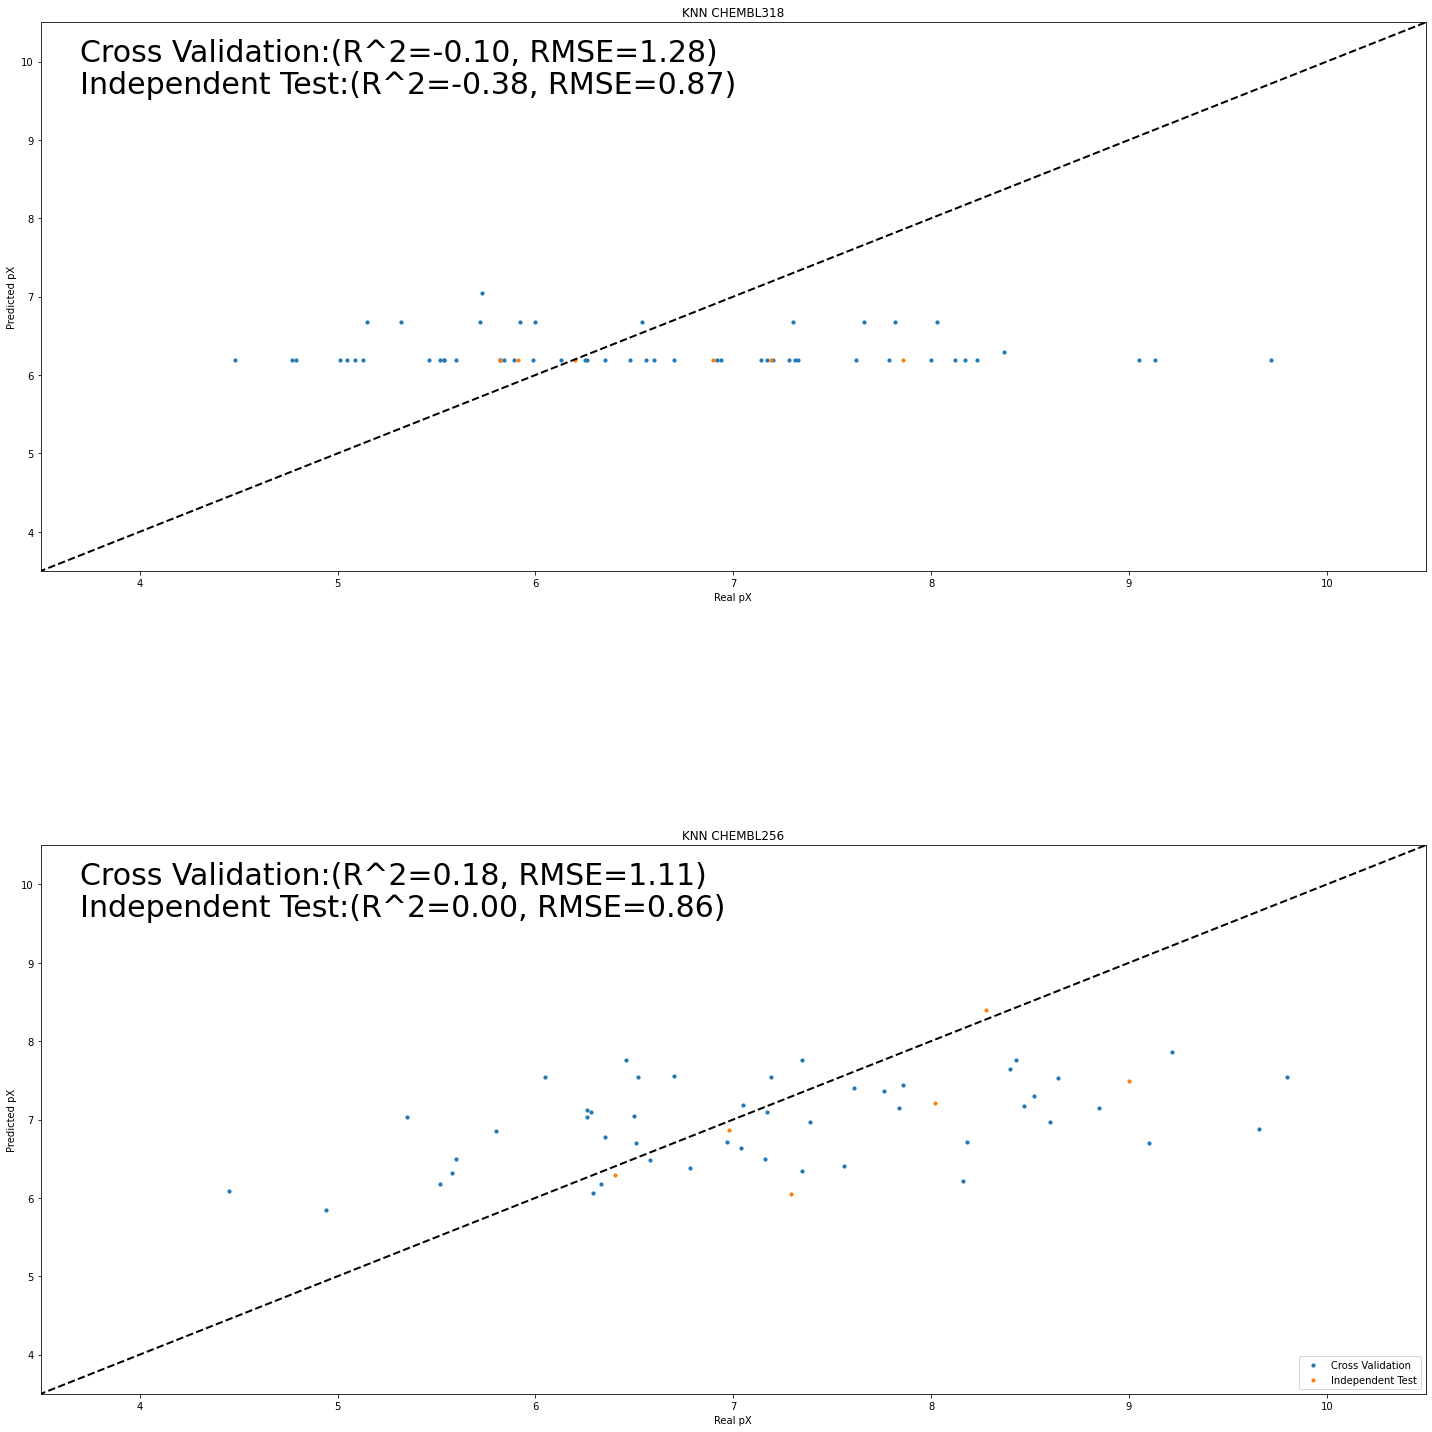

In [7]:
from matplotlib import pyplot as plt
from sklearn import metrics

def QSAR_REG_scatterplot(infolder, targets, models, out=None):
    """
    Function to plot the results of regression models. Plot predicted pX vs real pX. 
    """
    plt.figure(figsize=(20, 20))
    for i, target in enumerate(targets):
        cate = ['cv', 'ind']
        for m, model in enumerate(models):
            plt.subplot(len(targets),len(models),1 + i*len(models) + m)
            for j, legend in enumerate(['Cross Validation', 'Independent Test']):
                df = pd.read_table('%s/%s_REG_%s.%s.tsv' % (infolder, model, target, cate[j]))
                plt.scatter(df.Label, df.Score, s=10, label=legend)
                coef = metrics.r2_score(df.Label, df.Score)
                rmse = metrics.mean_squared_error(df.Label, df.Score, squared=False)
                plt.annotate('%s:(R^2=%.2f, RMSE=%.2f)' % (legend,coef, rmse), xy=[3.7,10-0.4*j],fontsize=30)

            plt.title('%s %s' % (model,target))
            plt.xlim([3.5, 10.5])
            plt.ylim([3.5, 10.5])
            plt.xlabel('Real pX')
            plt.ylabel('Predicted pX')
            plt.plot([0, 11], [0, 11], color='black', lw=2, linestyle='--')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.subplots_adjust(wspace = 0.3, hspace = 0.5) 
    if out is None:
        plt.show()
    else:
        plt.savefig("%s.pdf" % out, dpi=300)

QSAR_REG_scatterplot(infolder='envs', targets=['CHEMBL318', 'CHEMBL256'], models=['KNN'])

<a id='scoring'></a>

### Designating Scoring Functions

Now we can wrap the built models in the `ModelScorer` class, which extends the `Scorer` interface to facilitate compound scoring during reinforcement learning:

In [8]:
from drugex.training.scorers.predictors import Predictor
from drugex.training.interfaces import Scorer

class ModelScorer(Scorer):
    
    def __init__(self, model, prefix):
        super().__init__()
        self.model = model
        self.prefix = prefix
    
    def getScores(self, mols, frags=None):
        X = Predictor.calculateDescriptors(mols)
        return self.model.predict(X)
    
    def getKey(self):
        return f"{self.prefix}_{type(self.model)}"
    
scorer_a1 = ModelScorer(knn_a1.model, 'A1')
scorer_a3 = ModelScorer(knn_a3.model, 'A3')

Instances of this class serve as scoring functions that are used to calculate the rewards in reinforcement learning. We can show how scoring works on a simple example of caffeine:

In [9]:
scorer_a1(["CN1C=NC2=C1C(=O)N(C(=O)N2C)C"])

array([6.19166667])

In [10]:
scorer_a3(["CN1C=NC2=C1C(=O)N(C(=O)N2C)C"])

array([6.418])

We can see that indeed our model for A1R might not be ideal in this case because the ChEMBL database actually reports pChEMBL values for caffeine in similar range for both targets (around 4.8).

#### Applying Modifiers

Next, we need to set proper modifiers for the scoring functions to calculate the correct rewards. You can again envisage different modifiers here that will mean different rewards, but we just use `ClippedScore` here:

In [11]:
from drugex.training.scorers.modifiers import ClippedScore

pad = 3.5
activity_threshold = 6.5

# inactive target
scorer_a1.setModifier(ClippedScore(lower_x=activity_threshold + pad, upper_x=activity_threshold))

# active target
scorer_a3.setModifier(ClippedScore(lower_x=activity_threshold - pad, upper_x=activity_threshold))

`ClippedScore` will change the previous values as follows:

In [12]:
scorer_a1(["CN1C=NC2=C1C(=O)N(C(=O)N2C)C"])

array([1.])

In [13]:
scorer_a3(["CN1C=NC2=C1C(=O)N(C(=O)N2C)C"])

array([0.97657143])

The intent of this modifier becomes clear when we plot the `ClippedScore` function for some example values:

<AxesSubplot:xlabel='Original', ylabel='ClippedScore'>

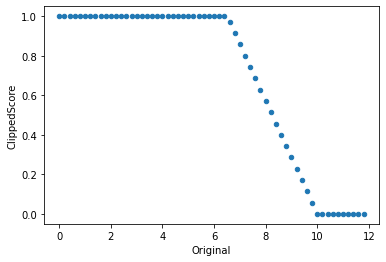

In [14]:
import numpy as np

def depict_modifier(modifier):
    vals = np.arange(0,12, 0.2)
    scores = [(x, modifier(x)) for x in vals] # get the A1R modifier for inactivity (the lower the activity, the higher the reward)
    scores = pd.DataFrame(scores, columns=['Original', 'ClippedScore'])
    return scores.plot.scatter(x = 'Original', y = 'ClippedScore')

depict_modifier(scorer_a1.getModifier())

Therefore, the score starts to deteriorate gradually as we cross the chosen `activity_threshold` (6.5) and becomes zero at `activity_threshold + pad`. When we show the same for our 'active' scoring function, the relationship is the exact opposite:

<AxesSubplot:xlabel='Original', ylabel='ClippedScore'>

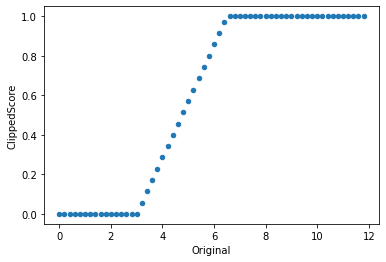

In [15]:
depict_modifier(scorer_a3.getModifier())

Therefore, we reward all molecules with a score above `activity_threshold` with 1.0 and all molecules predicted as inactive with scores below `activity_threshold - pad` get no reward.

In addition to these scores, we also implement two other scoring functions for a desired `QED` range and synthetic accessibility score (`SA`):

In [16]:
from drugex.training.scorers.properties import Property

qed = Property(
    "QED",
    modifier=ClippedScore(lower_x=0, upper_x=1.0)
)

sascore = Property(
    "SA",
    modifier=ClippedScore(lower_x=4.5, upper_x=0)
)

This concludes our definition of scoring functions. As the last step, we serialize our QSAR models so that we can use them for predictions on the generated molecules in the [generation tutorial](generation.ipynb): 

In [17]:
import pickle

models_dir = 'data/models/reinforced/graph'
os.makedirs(models_dir, exist_ok=True)
pickle.dump(scorer_a1, open(f'{models_dir}/scorer_a1.pkg', 'bw'))
pickle.dump(scorer_a3, open(f'{models_dir}/scorer_a3.pkg', 'bw'))

## Creating Environment

The environment for reinforcement learning has two main ingredients in DrugEx. The scoring functions we created above and thresholds:

In [18]:
from drugex.training.environment import DrugExEnvironment
from drugex.training.rewards import ParetoCrowdingDistance

scorers = [
    scorer_a1,
    scorer_a3,
    qed,
    sascore
]
thresholds = [
    0.99,
    0.99,
    0.0,
    0.0
]

environment = DrugExEnvironment(scorers, thresholds, reward_scheme=ParetoCrowdingDistance())

The thresholds are applied to the modified scores when the desirablity of the molecules is determined. Molecules with scores below the given thresholds are considered as undesired by DrugEx. This information is used during evaluation of the model and also calculation of some of the rewards (i.e. `drugex.training.rewards.WeightedSum`). However, in this case we will use the `ParetoCrowdingDistance` reward scheme, which calculates rewards based on Pareto ranking of the compounds in the space of objectives using the `NSGA-II` algorithm.

Now we have all ingredients to start optimization of our models. We can reuse the same environment for all models within DrugEx. As usual, we start with the graph-based solution:

## Graph-Based Model

In [19]:
from drugex.training.models.explorer import GraphExplorer
from drugex.training.models.transform import GraphModel
from drugex.data.corpus.vocabulary import VocGraph

vocabulary = VocGraph.fromFile('data/models/finetuned/graph/ligand_finetuned.vocab')
finetuned = GraphModel(voc_trg=vocabulary, use_gpus=GPUS)
finetuned.loadStatesFromFile('data/models/finetuned/graph/chembl_ligand.pkg')
pretrained = GraphModel(voc_trg=vocabulary, use_gpus=GPUS)
pretrained.loadStatesFromFile('jupyter/models/pretrained/graph/chembl27/chembl27_graph.pkg')

explorer = GraphExplorer(agent=pretrained, env=environment, mutate=finetuned, epsilon=0.1, use_gpus=GPUS)

Here we use the pretrained model as the agent for the reinforcement learning and the finetuned network will be our prior, which introduces mutations to the generated structures according to the exploration rate parameter `epsilon` (see [preprint](https://chemrxiv.org/engage/chemrxiv/article-details/61aa8b58bc299c0b30887f80)). 

We will also need the previously generated training and validation sets for finetuning to run the calculations:

In [20]:
from drugex.data.datasets import GraphFragDataSet

train = GraphFragDataSet('data/sets/graph/ligand_train.tsv')
test = GraphFragDataSet('data/sets/graph/ligand_test.tsv')

After that we can finally start the training loop:

In [21]:
from drugex.training.monitors import FileMonitor

monitor = FileMonitor("data/models/reinforced/graph/agent", verbose=True) # we can use the same monitor type for all models in DrugEx
explorer.fit(train.asDataLoader(batch_size=128), test.asDataLoader(batch_size=128), monitor=monitor, epochs=EPOCHS)

Fitting graph explorer:   0%|          | 0/3 [00:00<?, ?it/s]

Iterating over training batches:   0%|          | 0/19 [00:00<?, ?it/s]

Iterating over validation batches:   0%|          | 0/19 [00:00<?, ?it/s]

/home/sichom/projects/DrugEx/drugex/training/models/explorer.py:194: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  reward = torch.Tensor(reward).to(src.device)


Iterating over training batches:   0%|          | 0/19 [00:00<?, ?it/s]

Iterating over validation batches:   0%|          | 0/19 [00:00<?, ?it/s]

Iterating over training batches:   0%|          | 0/19 [00:00<?, ?it/s]

Iterating over validation batches:   0%|          | 0/19 [00:00<?, ?it/s]

Finally, we just save the used vocabulary again for future reference:

In [22]:
vocabulary.toFile('data/models/reinforced/graph/agent.vocab')

We can again use the monitor's output to see how our model performed during training and to plot results more easily:

In [23]:
df_info = pd.read_csv('data/models/reinforced/graph/agent_fit.tsv', sep='\t')
df_info

,epoch,loss_valid,valid_ratio,unique_ratio,desire_ratio,mean_train_loss
0,1,NaN,1.0,1.0,1.0,0.865075
1,2,NaN,1.0,1.0,1.0,0.624897
2,3,NaN,1.0,1.0,1.0,0.476756


<AxesSubplot:xlabel='epoch'>

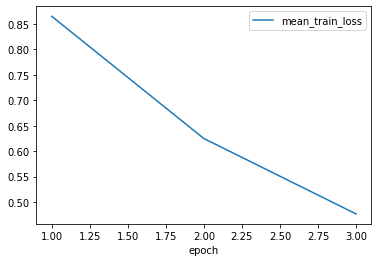

In [24]:
df_info.plot.line(x='epoch', y='mean_train_loss')

In the detailed output for the molecules generated, we can see that the structures are mostly undesireble, but that was to be expected because we are only training for a small number of epochs with a small data set:

In [25]:
df_smiles = pd.read_csv('data/models/reinforced/graph/agent_smiles.tsv', sep='\t')
df_smiles

,Smiles,A1_<class 'sklearn.neighbors._regression.KNeighborsRegressor'>,A3_<class 'sklearn.neighbors._regression.KNeighborsRegressor'>,QED,SA,DESIRE,VALID,Frag,Epoch
0,CCC(O)C(c1cccc(N2CCC(c3ccncc3)C2)c1)c1nc(-c2cc...,1.0,1.0,0.337392,0.112274,1.0,1.0,CCC.c1ccncc1,1
1,CNc1nc(OCC2CC2)nc(C2CCN(C(=O)c3ccnn3C)C2)n1,1.0,1.0,0.825392,0.265718,1.0,1.0,Cn1cccn1,1
2,Cc1ccc(C)c(CN(CCc2ccc(Cl)cc2)Cc2ccccc2)c1,1.0,1.0,0.482538,0.590344,1.0,1.0,Clc1ccccc1,1
3,Nc1sc2c(c1C(=O)Nc1ccc(I)c3ccccc13)CCNC2,1.0,1.0,0.518855,0.417650,1.0,1.0,C=O.Ic1cccc2ccccc12.Nc1cc2c(s1)CNCC2,1
4,Nc1nc(SCN2CCN3CCCC3C2)nc2nc(-c3ccco3)nn12,1.0,1.0,0.676593,0.242222,1.0,1.0,C1CC2CNCCN2C1.Nc1ncnc2ncnn12.c1ccoc1,1
...,...,...,...,...,...,...,...,...,...
970,NN=c1cc2ccoc2cn1CC1C=CCC1,1.0,1.0,0.486041,0.084555,1.0,1.0,C1=CCCC1,3
971,CC=CP(=O)(NC(=O)C(CC1NC(=O)NC1=O)c1ccncc1)OCC1...,1.0,1.0,0.274470,0.000000,1.0,1.0,OC1COCC1O,3
972,O=c1c2c(-c3ccc(Cl)cc3)noc2ccn1CCCc1ccccc1,1.0,1.0,0.503455,0.512422,1.0,1.0,Clc1ccccc1,3
973,CCCCC1C(=COc2cccnc2)CCC=C2C(=O)C(Nc3cccc(C(F)F...,1.0,1.0,0.473686,0.107033,1.0,1.0,CCC.c1ccncc1,3
